In [115]:
import pandas as pd
from ydata_profiling import ProfileReport

# Remove linhas duplicadas
def remover_duplicatas(df):
    tamanho_antes = df.shape[0]
    df = df.drop_duplicates()
    tamanho_depois = df.shape[0]
    print(f"Foram removidas {tamanho_antes - tamanho_depois} linhas duplicadas.")
    return df

# Função auxiliar: Normaliza colunas numéricas
def normalizar_colunas(df, colunas):
    for col in colunas:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

df = pd.read_csv('assets/BancoVDE 2024.csv', sep=';')
df = df.drop(columns=['formulario', 'abrangencia'])
df = remover_duplicatas(df)

C:\Users\Filipe\AppData\Local\Temp\ipykernel_27176\2797724655.py:18: DtypeWarning: Columns (4,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('assets/BancoVDE 2024.csv', sep=';')


Foram removidas 0 linhas duplicadas.


In [116]:
df = df[~df['evento'].isin([
    'Atendimento pré-hospitalar',
    'Busca e salvamento',
    'Combate a incêndios',
    'Emissão de Alvarás de licença',
    'Realização de vistorias',
    'Suicídio de Agente do Estado',
    'Tentativa de feminicídio',
    'Roubo a instituição financeira',
    'Roubo de carga',
    'Roubo de veículo',
    'Tentativa de homicídio',
    'Mortes a esclarecer (sem indício de crime)'
])]

In [117]:
print(df['evento'].unique())

['Apreensão de Cocaína' 'Apreensão de Maconha' 'Arma de Fogo Apreendida'
 'Estupro' 'Estupro de vulnerável' 'Feminicídio' 'Furto de veículo'
 'Homicídio doloso' 'Lesão corporal seguida de morte'
 'Mandado de prisão cumprido' 'Morte de Agente do Estado'
 'Morte no trânsito ou em decorrência dele (exceto homicídio doloso)'
 'Morte por intervenção de Agente do Estado' 'Pessoa Desaparecida'
 'Pessoa Localizada' 'Roubo seguido de morte (latrocínio)' 'Suicídio'
 'Tráfico de drogas']


In [118]:
print(df.shape[0])
print(df.columns)

482880
Index(['uf', 'municipio', 'evento', 'data_referencia', 'agente', 'arma',
       'faixa_etaria', 'feminino', 'masculino', 'nao_informado',
       'total_vitima', 'total', 'total_peso'],
      dtype='object')


In [119]:
# Dicionário para armazenar dataframes por 'evento'
from collections import defaultdict

sub_dfs = {}

# Itera sobre valores únicos de 'evento' e cria dataframes limpos
for evento in df['evento'].unique():
    sub_df = df[df['evento'] == evento].copy()
    # Remove colunas totalmente NaN para este nicho
    sub_df = sub_df.dropna(axis=1, how='all')
    sub_dfs[evento] = sub_df

# Imprime o shape e as colunas de cada sub_df
for evento, sub_df in sub_dfs.items():
    print(f"Evento: {evento}")
    print(sub_df.shape)
    print(sub_df.columns)
    print('-' * 40)

# Agrupa eventos pelo número de linhas em seu sub_df
grupos_linhas = defaultdict(list)
for evento, sub_df in sub_dfs.items():
    grupos_linhas[sub_df.shape[0]].append(evento)

# Imprime o agrupamento
for n_linhas, eventos in sorted(grupos_linhas.items(), reverse=True):
    print(f"{n_linhas} linhas: {eventos}")


Evento: Apreensão de Cocaína
(324, 5)
Index(['uf', 'municipio', 'evento', 'data_referencia', 'total_peso'], dtype='object')
----------------------------------------
Evento: Apreensão de Maconha
(324, 5)
Index(['uf', 'municipio', 'evento', 'data_referencia', 'total_peso'], dtype='object')
----------------------------------------
Evento: Arma de Fogo Apreendida
(2916, 6)
Index(['uf', 'municipio', 'evento', 'data_referencia', 'arma', 'total'], dtype='object')
----------------------------------------
Evento: Estupro
(324, 8)
Index(['uf', 'municipio', 'evento', 'data_referencia', 'feminino', 'masculino',
       'nao_informado', 'total_vitima'],
      dtype='object')
----------------------------------------
Evento: Estupro de vulnerável
(324, 8)
Index(['uf', 'municipio', 'evento', 'data_referencia', 'feminino', 'masculino',
       'nao_informado', 'total_vitima'],
      dtype='object')
----------------------------------------
Evento: Feminicídio
(67548, 8)
Index(['uf', 'municipio', 'evento',

In [55]:
sub_dfs['Arma de Fogo Apreendida'] = sub_dfs['Arma de Fogo Apreendida'].groupby(['uf', 'data_referencia'])['total'].sum().reset_index()
sub_dfs['Morte de Agente do Estado'] = sub_dfs['Morte de Agente do Estado'].groupby(['uf', 'data_referencia'])['total_vitima'].sum().reset_index()
sub_dfs['Pessoa Desaparecida'] = sub_dfs['Pessoa Desaparecida'].groupby(['uf', 'data_referencia'])['total_vitima'].sum().reset_index()
sub_dfs['Pessoa Localizada'] = sub_dfs['Pessoa Localizada'].groupby(['uf', 'data_referencia'])['total_vitima'].sum().reset_index()

In [56]:
grupos_linhas[324].extend(['Arma de Fogo Apreendida','Morte de Agente do Estado','Pessoa Desaparecida', 'Pessoa Localizada'])

In [120]:
for evento in grupos_linhas[67548]:
    sub_dfs[evento] = sub_dfs[evento][sub_dfs[evento]['municipio'] != 'NÃO INFORMADO']
    

In [121]:
for evento in grupos_linhas[324] + grupos_linhas[2916] + grupos_linhas[972]:
    print(f"Evento: {evento}")
    if 'total' in sub_dfs[evento].columns:
        sub_dfs[evento] = sub_dfs[evento].groupby(['uf', 'data_referencia'])['total'].sum().reset_index()
    if 'total_vitima' in sub_dfs[evento].columns:
        sub_dfs[evento] = sub_dfs[evento].groupby(['uf', 'data_referencia'])['total_vitima'].sum().reset_index()
    sub_dfs[evento].drop(columns=['municipio'], inplace=True, errors='ignore')
    print(sub_dfs[evento].columns)

Evento: Apreensão de Cocaína
Index(['uf', 'evento', 'data_referencia', 'total_peso'], dtype='object')
Evento: Apreensão de Maconha
Index(['uf', 'evento', 'data_referencia', 'total_peso'], dtype='object')
Evento: Estupro
Index(['uf', 'data_referencia', 'total_vitima'], dtype='object')
Evento: Estupro de vulnerável
Index(['uf', 'data_referencia', 'total_vitima'], dtype='object')
Evento: Furto de veículo
Index(['uf', 'data_referencia', 'total'], dtype='object')
Evento: Morte por intervenção de Agente do Estado
Index(['uf', 'data_referencia', 'total_vitima'], dtype='object')
Evento: Tráfico de drogas
Index(['uf', 'data_referencia', 'total'], dtype='object')
Evento: Arma de Fogo Apreendida
Index(['uf', 'data_referencia', 'total'], dtype='object')
Evento: Morte de Agente do Estado
Index(['uf', 'data_referencia', 'total_vitima'], dtype='object')
Evento: Pessoa Desaparecida
Index(['uf', 'data_referencia', 'total_vitima'], dtype='object')
Evento: Pessoa Localizada
Index(['uf', 'data_referencia'

In [122]:
grupos_linhas[324].extend(grupos_linhas[2916] + grupos_linhas[972])

In [123]:
from functools import reduce

# Combina os dataframes para eventos em grupos_linhas[324]
dfs = []
for evento in grupos_linhas[324]:
    df_evento = sub_dfs[evento].copy()
    # Remove a coluna 'evento' se existir
    if 'evento' in df_evento.columns:
        df_evento = df_evento.drop(columns=['evento'])
    # Minúsculas e normaliza o nome do evento para prefixo de coluna
    prefixo = evento.lower().replace('ã', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace('ç', 'c')
    # Renomeia colunas exceto 'uf' e 'data_referencia'
    novas_colunas = {}
    for col in df_evento.columns:
        if col not in ['uf', 'data_referencia']:
            novas_colunas[col] = f"{prefixo}"
    df_evento = df_evento.rename(columns=novas_colunas)
    dfs.append(df_evento.set_index(['uf', 'data_referencia']))

# Faz o merge de todos pelo índice
dados_estaduais_agregados = reduce(lambda esquerda, direita: esquerda.join(direita, how='outer'), dfs)
dados_estaduais_agregados.reset_index(inplace=True)
_, dados_estaduais_agregados['data_referencia'], _ = zip(*dados_estaduais_agregados['data_referencia'].str.split('/').to_list())

In [127]:
dados_estaduais_agregados.columns

Index(['uf', 'data_referencia', 'apreensao de cocaina', 'apreensao de maconha',
       'estupro', 'estupro de vulnerável', 'furto de veiculo',
       'morte por intervencao de agente do estado', 'tráfico de drogas',
       'arma de fogo apreendida', 'morte de agente do estado',
       'pessoa desaparecida', 'pessoa localizada'],
      dtype='object')

ValueError: Could not interpret value `x` for `x`. An entry with this name does not appear in `data`.

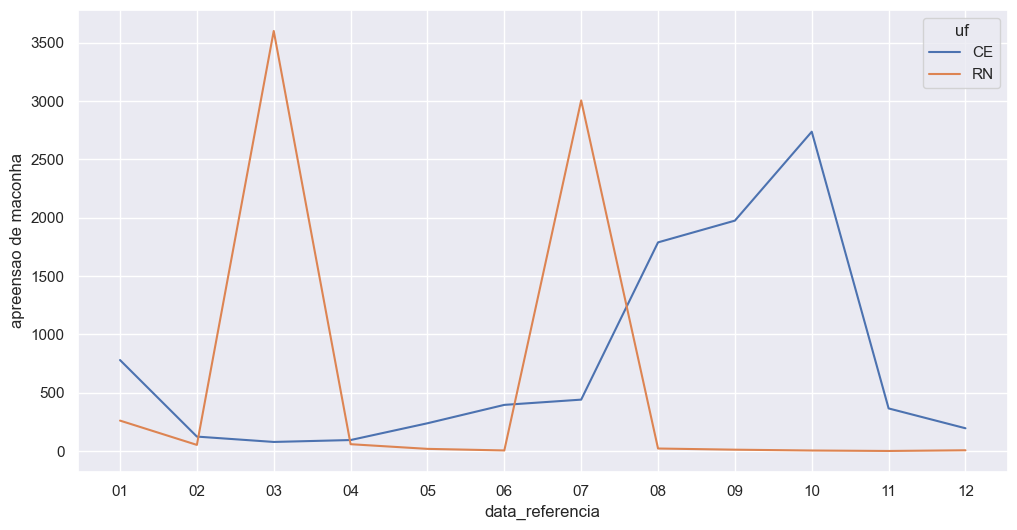

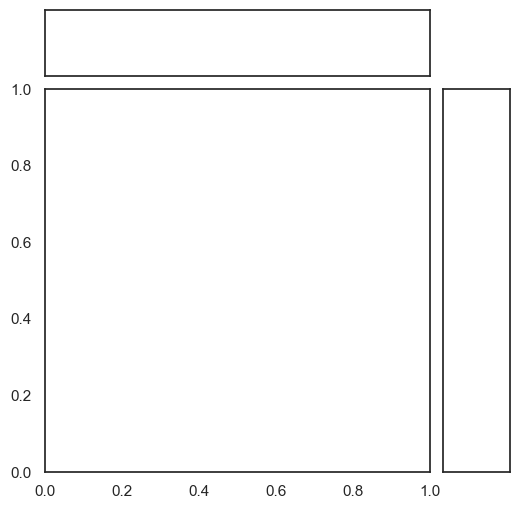

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()
# Filtra apenas as linhas de 'uf' RN e CE
df_maconha = dados_estaduais_agregados[dados_estaduais_agregados['uf'].isin(['RN', 'CE'])].copy()

# Converte a coluna de peso para float (substitui vírgula por ponto)
df_maconha['apreensao de maconha'] = df_maconha['apreensao de maconha'].str.replace(',', '.').astype(float)
df_maconha['apreensao de cocaina'] = df_maconha['apreensao de cocaina'].str.replace(',', '.').astype(float)

# Plota o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_maconha,
    x='data_referencia',
    y='apreensao de maconha',
    hue='uf',
)
with sns.axes_style('white'):
    sns.jointplot(x="tráfico de drogas", y="arma de fogo apreendida", data=df_maconha[['tráfico de drogas', 'arma de fogo apreendida']], kind='kde');
plt.title('Apreensão de Maconha - RN vs CE')
plt.xlabel('Data de Referência')
plt.ylabel('Apreensão de Maconha (kg)')
plt.tight_layout()
plt.show()

In [126]:
ProfileReport(dados_estaduais_agregados, title="Dados dos Estados", explorative=True).to_file("relatorio_df_estados.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 3338.19it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]